# NetCDF Zarr Sequential Recipe: CMIP6

This tutorial describes how to create a suitable recipe for many of the CMIP6 datasets.
The source data is a sequence of NetCDF files accessed from the 's3://esgf-world' bucket.
The target is a Zarr store.

## Background

- The s3://esgf-world bucket has about 250,000 datasets stored in about 950,000 netcdf files (for an average of about four netcdf files per dataset). This is a small subset of the WCRP-CMIP6 collection available at the Federated ESGF-COG nodes such as https://esgf-node.llnl.gov/search/cmip6, but it is faster and easier to work with. 

- Each CMIP6 dataset can be identified by a 6-tuple consisting of:

        (model,experiment,ensemble_member,mip_table,variable,grid_label)
        
and so a convenient name for a particular dataset is a string of these values joined with a '.' separator:

      dataset = model.experiment.ensemble_member.mip_table.variable.grid_label
        

- There can be multiple versions of a dataset, designated by a string beginning with 'v' and then an 8 digit date, loosely associated with its creation time

In [1]:
import pandas as pd
import xarray as xr
import s3fs

## Step 1: Get to know your source data
The CMIP6 collection is very heterogeneous, so getting to know the source data is rather complicated. We first need to identify a dataset and learn how to list the set of netcdf files which are associated with it. Fortunately, you can explore the data here: https://esgf-world.s3.amazonaws.com/index.html#CMIP6/ or download a CSV file listing all of the netcdf files, one per line.

Here we will read the CSV file into a pandas dataframe so we can search, sort and subset the available datasets and their netcdf files.

In [2]:
netcdf_cat = 's3://cmip6-nc/esgf-world.csv.gz'
df_s3 = pd.read_csv(netcdf_cat, dtype='unicode')
df_s3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056266 entries, 0 to 1056265
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   project          1056266 non-null  object
 1   institution_id   1056266 non-null  object
 2   source_id        1056266 non-null  object
 3   experiment_id    1056266 non-null  object
 4   frequency        559718 non-null   object
 5   modeling_realm   559718 non-null   object
 6   table_id         1056266 non-null  object
 7   member_id        1056266 non-null  object
 8   grid_label       1056266 non-null  object
 9   variable_id      1056266 non-null  object
 10  temporal_subset  1027893 non-null  object
 11  version          1056266 non-null  object
 12  path             1056266 non-null  object
dtypes: object(13)
memory usage: 104.8+ MB


In [3]:
# So there are 956,306 entries, one for each netcdf file. We can see the first five here:
# The 'path' column is the most important - you may need to scroll the window to see it!

df_s3.head()

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,AERmon,r1i1p1f1,gn,ps,185001-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
1,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,CFmon,r1i1p1f1,gn,ta,185001-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
2,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,LImon,r1i1p1f1,gn,snc,185002-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
3,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,LImon,r1i1p1f1,gn,snd,185002-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
4,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,LImon,r1i1p1f1,gn,snw,185002-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...


In [4]:
# We will add a new column which is our short name for the datasets (may take a moment for all 956306 rows)
df_s3['dataset'] = df_s3.apply(lambda row: '.'.join(row.path.split('/')[6:12]),axis=1)
# the number of unique dataset names can be found using the 'nunique' method
df_s3.dataset.nunique()

239268

In [5]:
# The value in the `path` column of the first row is:
df_s3.path.values[0]

's3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/ps_AERmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc'

In [6]:
# which has the short name:
df_s3.dataset.values[0]

'TaiESM1.histSST-piNTCF.r1i1p1f1.AERmon.ps.gn'

In [7]:
# some datasets have multiple versions: (will just check one in each 500 of them ...)
for dataset in df_s3.dataset.unique()[::500]:
    df_dataset = df_s3[df_s3.dataset==dataset]
    if df_dataset.version.nunique() > 1:
        print(dataset,df_dataset.version.unique())

EC-Earth3-LR.piControl.r1i1p1f1.Omon.mlotst.gn ['v20200409' 'v20200919']
FIO-ESM-2-0.piControl.r1i1p1f1.Amon.rsds.gn ['v20190911' 'v20191010']
IPSL-CM6A-LR.piControl.r1i1p1f1.Amon.o3.gr ['v20181022' 'v20181123']
CESM2.1pctCO2.r1i1p1f1.day.zg.gn ['v20190425' 'v20190826']
NorCPM1.historical.r1i1p1f1.Omon.thetao.gr ['v20190914' 'v20200724']
NorESM2-LM.piControl.r1i1p1f1.Ofx.areacello.gn ['v20190815' 'v20190920']
NorESM2-LM.hist-GHG.r1i1p1f1.Emon.va.gn ['v20190909' 'v20191108']
CESM2.deforest-globe.r1i1p1f1.Amon.rsuscs.gn ['v20190401' 'v20191122']


In [8]:
# So pick a dataset, any dataset, and try it!  N.B. some datasets are VERY large - especially the day, 6hourly, etc.
#dataset = df_s3.dataset[10450]
# or:
dataset = 'GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1'

In [9]:
df_dataset = df_s3[df_s3.dataset==dataset]
df_dataset

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path,dataset
603842,CMIP6,NOAA-GFDL,GFDL-CM4,historical,mon,atmos,Amon,r1i1p1f1,gr1,tas,185001-194912,v20180701,s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/...,GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1
603843,CMIP6,NOAA-GFDL,GFDL-CM4,historical,mon,atmos,Amon,r1i1p1f1,gr1,tas,195001-201412,v20180701,s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/...,GFDL-CM4.historical.r1i1p1f1.Amon.tas.gr1


**So is this what we expect?**
- this dataset is split over 3 netcdf files - see any trouble here?
- lets do a quick sanity check (make sure one and only one variable is specified) and get only the latest version of the files

In [10]:
dvars = df_dataset.variable_id.unique()
assert len(dvars) > 0, 'no netcdf files found for this dataset'
assert len(dvars) == 1, f"trouble with this dataset, too many datasets found: {dvars}"
    
var = dvars[0]
print('The variable is:',var)

# make sure we are looking at the last available version:
last_version = sorted(df_dataset.version.unique())[-1]
dze = df_dataset[df_dataset.version == last_version].reset_index(drop=True)

input_urls = sorted(dze.path.unique())
input_urls

The variable is: tas


['s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_185001-194912.nc',
 's3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_195001-201412.nc']

**There are only two files - one netcdf file was from an older version!**
- We want to look at the first netcdf file to make sure we know what to expect
- To use `xarray.open_dataset`, we need to turn the input_url (starting with 's3://') into an appropriate file_like object.

In [11]:
# Connect to AWS S3 storage
fs_s3 = s3fs.S3FileSystem(anon=True)

file_url = fs_s3.open(input_urls[0], mode='rb')
ds = xr.open_dataset(file_url)
print(ds)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1200)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 1949-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/46)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant

## Step 2: Deciding how to chunk the dataset
- For parallel I/O and subsetting the dataset in time, we will chunk the data in the time dimension
- In order to figure out the number of time slices in each chunk, we do a small calculation on the first netcdf file
- Here we set the desired chunk size to 50 Mb, but something between 50-100 Mb is usually alright

In [12]:
#ntime = len(ds.time)       # the number of time slices
#chunksize_optimal = 50e6  # desired chunk size in bytes
#ncfile_size = ds.nbytes    # the netcdf file size
#chunksize = max(int(ntime* chunksize_optimal/ ncfile_size),1)

#target_chunks = ds.dims.mapping
#target_chunks['time'] = chunksize

# Remove the comments above to recalculate
target_chunks = {'bnds': 2, 'lat': 180, 'lon': 288, 'time': 241}
target_chunks   # a dictionary giving the chunk sizes in each dimension

{'bnds': 2, 'lat': 180, 'lon': 288, 'time': 241}

## Step 3: Define the File Pattern
- A `FilePattern` is the starting place for all recipes. These Python objects are the "raw ingredients" upon which the recipe will act. They describe how the individual source files are organized logically as part of a larger dataset. To create a file pattern, the first step is to define a function which takes any variable components of the source file path as inputs, and returns full file path strings.
- Revisting our input urls, we see that the only variable components of these paths are the 13-character numerical strings which immediatly precede the .nc file extension:

In [13]:
for url in input_urls:
    print(f'''{url}
    ''')

s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_185001-194912.nc
    
s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_195001-201412.nc
    


**What do these strings refer to?**
- If it was not immediately apparent, comparison to our dataset coordinates makes it clear that these numerical strings are time ranges; the string `'185001-194912'` from the first url, e.g., represents a time range from Jan 1850 through Dec 1949:

In [14]:
print(ds.coords)

Coordinates:
  * bnds     (bnds) float64 1.0 2.0
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 1949-12-16 12:00:00


**Let's define a function that takes these strings as input**
- ... and returns full file paths!

In [15]:
def make_full_path(time):
    '''
    Parameters
    ----------
    time : str
    
        A 13-character string, comprised of two 6-character dates delimited by a dash. 
        The first four characters of each date are the year, and the final two are the month.
        
        e.g. The time range from Jan 1850 through Dec 1949 is expressed as '185001-194912'.
            
    '''
    base_url = 's3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/'
    return base_url + f'tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_{time}.nc'

In [16]:
# And let's be sure to test our function before moving on.

test_url = make_full_path('185001-194912')
print(test_url)

# If our function works, inputting '185001-194912' should have returned a url identical to
# the first of the two urls in the list named `input_urls` defined in cell 10, above:

test_url == input_urls[0]

s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_185001-194912.nc


True

**Combining dimensions**
- Before we initialize our file pattern, we need to define how we want files to be combined in our eventual zarr store
- We have two options:

    1. Concatenating dimensions with a `ConcatDim` instance
    2. Merging dimensions with a `MergeDim` instance
    
    
- Our current dataset requires only concatenation, which we can achieve by instantiating `ConcatDim` with our variable name (`"time"`) as a positional argument, followed by a `keys` kwarg, which is a list containing all of the ways which this variable appears in our set of source file paths.

> **Note:** This example reads from only two source files, so we can simply copy-and-paste their respective time variables into a list. If the number of source files was much larger, we might consider finding a way to create this `keys` list programatically.

In [17]:
from pangeo_forge_recipes.patterns import ConcatDim
time_concat_dim = ConcatDim("time", keys=['185001-194912', '195001-201412'])

**Instantiating the file pattern**
- Now that we have a both file path function and our "combine dimensions" object, we can move on to instantiating to file pattern, passing these two objects as arguments.
- Note that we will use `fsspec.open` under the hood for most file opening, so if there are any special keyword arguments we want to pass to this function, now is the time to do it.
- Here we specify `fsspec_open_kwargs={'anon':True}` as a keyword argument in the `FilePattern`, because we want to access the source files anonymously.

In [18]:
from pangeo_forge_recipes.patterns import FilePattern
pattern = FilePattern(make_full_path, time_concat_dim, fsspec_open_kwargs={'anon':True})
pattern

<FilePattern {'time': 2}>

> By inspecting our instantiated pattern we see that our pattern has indexed our two files chronologically according to the concatenation key we provided it, and assigned the correct url to each file using the file path function:

In [19]:
for index, fname in pattern.items():
    print(index, fname)

{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(value=0, indexed=False)} s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_185001-194912.nc
{Dimension(name='time', operation=<CombineOp.CONCAT: 2>): Position(value=1, indexed=False)} s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_195001-201412.nc


## Step 4: Write the Recipe

Now that we have a `FilePattern`, we are ready to write our recipe. As described in {doc}`netcdf_zarr_sequential`, a recipe is defined as a pipeline of [Apache Beam transforms](https://beam.apache.org/documentation/programming-guide/#transforms) applied to the data collection associated with a `FilePattern`.

First, we'll import the transforms provided by Pangeo Forge that may be used to transform a `FilePattern` collection into a Zarr store.

In [20]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr

### Define a pre-processing function

- This is an optional step which we want to apply to each chunk
- Here we change some data variables into coordinate variables, but you can define your own pre-processing step here

We will write a Beam transform that fixes both these issues. This is achieved by creating a [composite transform](https://beam.apache.org/documentation/programming-guide/#composite-transform-creation), which is a subclass of the `apache_beam.PTransform` class that overrides the `expand()` method to specify the actual processing logic. 

In [21]:
from pangeo_forge_recipes.transforms import Indexed, T

class SetBndsAsCoords(beam.PTransform):
    """
    Fix issues in retrieved data.
    """

    @staticmethod
    def _set_bnds_as_coords(item: Indexed[T]) -> Indexed[T]:
        """
        The netcdf lists some of the coordinate variables as data variables. 
        This is a fix which we want to apply to each dataset.
        """
        index, ds = item
        new_coords_vars = [var for var in ds.data_vars if 'bnds' in var or 'bounds' in var]
        ds = ds.set_coords(new_coords_vars)
        return index, ds

    def expand(self, pcoll: beam.PCollection) -> beam.PCollection:
        return pcoll | beam.Map(self._set_bnds_as_coords)

### Define the Recipe Object
The recipe pipeline of transforms applied to `pattern` is similar to that described in {doc}`netcdf_zarr_sequential`, with the following modifications:
1. `open_kwargs={'anon':True}` is specified to `OpenURLWithFSSpec`, because we want to access the source files anonymously.
1. The new preprocessing transform `SetBndsAsCoords` is included in the pipeline.

A place for our data to go

In [22]:
import os
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_root = td.name
store_name = "output.zarr"
target_store = os.path.join(target_root, store_name)

In [23]:
transforms = (
    beam.Create(pattern.items())
    | OpenURLWithFSSpec(open_kwargs={'anon':True})
    | OpenWithXarray(file_type=pattern.file_type)
    | SetBndsAsCoords() # New preprocessor
    | StoreToZarr(
        store_name=store_name,
        target_root=target_root,
        combine_dims=pattern.combine_dim_keys,
        target_chunks=target_chunks
    )
)
transforms

<_ChainedPTransform(PTransform) label=[Create|OpenURLWithFSSpec|OpenWithXarray|SetBndsAsCoords|StoreToZarr] at 0x7fc01da350d0>

## Step 5: Execute the recipe

Execute the recipe pipeline using Beam.

In [24]:
with beam.Pipeline() as p:
    p | transforms

## Step 6: Check the resulting Zarr store

In [25]:
# Check to see if it worked:
ds = xr.open_zarr(target_store)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) float64 15.5 45.0 74.5 ... 6.015e+04 6.018e+04 6.021e+04
    time_bnds  (time, bnds) float64 dask.array<chunksize=(241, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(241, 180, 288), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1

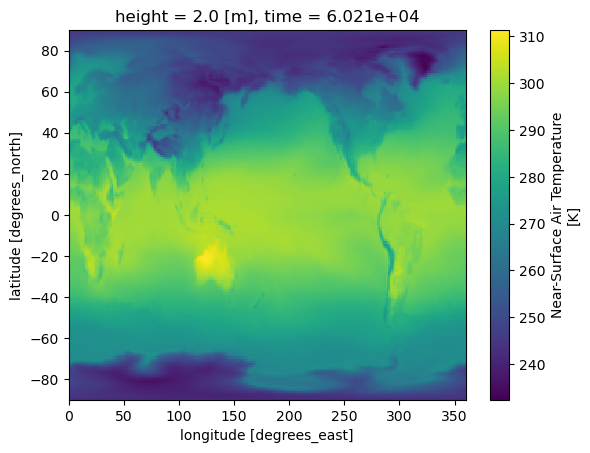

In [26]:
ds[var][-1].plot()

## Postscript
- If you find a CMIP6 dataset for which this recipe does not work, Please report it at [issue#105](https://github.com/pangeo-forge/pangeo-forge-recipes/issues/105) so we can refine the recipe, if possible.


In [27]:
# Troubles found:

dataset = 'IPSL-CM6A-LR.abrupt-4xCO2.r1i1p1f1.Lmon.cLeaf.gr'  # need decode_coords=False in xr.open_dataset, but using xarray_open_kwargs = {'decode_coords':False}, still throws an error when caching the input 